In [37]:
# Import requirements
from gurobipy import *
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
import requests_cache

In [38]:
# Set parameters
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
start = datetime.datetime(2015, 11, 22)
end = datetime.datetime(2017, 11, 22)

AA = web.DataReader("PETR4.SA", 'yahoo', start, end, session=session)['Adj Close']
BB = web.DataReader("VALE3.SA", 'yahoo', start, end, session=session)['Adj Close']
CC = web.DataReader("USIM5.SA", 'yahoo', start, end, session=session)['Adj Close']
DD = web.DataReader("GOAU4.SA", 'yahoo', start, end, session=session)['Adj Close']
EE = web.DataReader("ITSA4.SA", 'yahoo', start, end, session=session)['Adj Close']
FF = web.DataReader("ABEV3.SA", 'yahoo', start, end, session=session)['Adj Close']
GG = web.DataReader("RAIL3.SA", 'yahoo', start, end, session=session)['Adj Close']
HH = web.DataReader("JBSS3.SA", 'yahoo', start, end, session=session)['Adj Close']
II = web.DataReader("BVMF3.SA", 'yahoo', start, end, session=session)['Adj Close']
JJ = web.DataReader("CSNA3.SA", 'yahoo', start, end, session=session)['Adj Close']

In [226]:
absolutos = pd.concat([AA, BB, CC, DD, EE, FF, GG, HH, II, JJ], axis=1)
absolutos.columns = ['PETR4.SA', 'VALE3.SA', 'USIM5.SA', 'GOAU4.SA', 'ITSA4.SA', 'ABEV3.SA', 'RAIL3.SA', 'JBSS3.SA', 'BVMF3.SA', 'CSNA3.SA']

dados = (absolutos / absolutos.shift() - 1)

In [227]:
# TODO: Tratamento de missing values
# Gerar dados baseados na média e variância (retornos normais?)
teste = pd.DataFrame(dados['PETR4.SA'])
teste[251:] = np.nan

#teste[np.isnan(teste)] = teste[np.isnan(teste)].apply(lambda v: np.random.normal(loc=teste.mean(), scale=teste.std()))

#print(teste)
#print(dados['PETR4.SA'])
#print(dados['PETR4.SA'].mean())
#print(teste.mean())

            PETR4.SA
Date                
2015-11-23       NaN
2015-11-24  0.051980
2015-11-25 -0.070588
2015-11-26  0.002532
2015-11-27 -0.040404
2015-11-30  0.009211
2015-12-01 -0.023468
2015-12-02  0.004005
2015-12-03  0.061170
2015-12-04 -0.057644
2015-12-07 -0.043883
2015-12-08 -0.008345
2015-12-09  0.072931
2015-12-10 -0.026144
2015-12-11 -0.026846
2015-12-14 -0.005517
2015-12-15  0.029126
2015-12-16 -0.017520
2015-12-17 -0.012346
2015-12-18 -0.025000
2015-12-21 -0.054131
2015-12-22  0.022590
2015-12-23  0.020619
2015-12-28 -0.033189
2015-12-29 -0.001493
2015-12-30  0.001495
2016-01-04  0.025373
2016-01-05 -0.027656
2016-01-06 -0.041916
2016-01-07 -0.021875
...              ...
2017-10-12       NaN
2017-10-13       NaN
2017-10-16       NaN
2017-10-17       NaN
2017-10-18       NaN
2017-10-19       NaN
2017-10-20       NaN
2017-10-23       NaN
2017-10-24       NaN
2017-10-25       NaN
2017-10-26       NaN
2017-10-27       NaN
2017-10-30       NaN
2017-10-31       NaN
2017-11-01   

In [40]:
# Variáveis dos dados
produtos = dados.columns
desvios = dados.std()
retornos = dados.mean()
sigma = dados.cov()

# Modelo
m = Model('carteira')
pesos = pd.Series(m.addVars(produtos), index=produtos)
carteira_risco = sigma.dot(pesos).dot(pesos)
carteira_retorno = retornos.dot(pesos)

m.setObjective(carteira_risco, GRB.MINIMIZE)

m.addConstr(pesos.sum() == 1, 'riqueza')

m.setParam('OutputFlag', 0)
m.optimize()

In [41]:
# Peso de cada ativo
print('Menor Risco:\n')
for peso in pesos:
    if peso.x > 0:
        print('\t%s\t: %g' % (peso.varname, peso.x))

# Retorno médio e desvio padrão
risco_minimo_desvio = sqrt(carteira_risco.getValue())
risco_minimo_retorno = carteira_retorno.getValue()

print('\nDesvio padrão = %g' % risco_minimo_desvio)
print('Retorno médio = %g' % risco_minimo_retorno)

Menor Risco:

	C0	: 6.46482e-07
	C1	: 0.00234621
	C2	: 5.98072e-06
	C3	: 6.57505e-06
	C4	: 0.099679
	C5	: 0.791135
	C6	: 0.00486049
	C7	: 0.0310098
	C8	: 0.0709552
	C9	: 8.26958e-07

Desvio padrão = 0.0119359
Retorno médio = 0.000510721


In [42]:
# Retorno desejado
retorno_alvo = m.addConstr(carteira_retorno == risco_minimo_retorno, 'retorno_alvo')

# Fronteira eficiente
fronteira_eficiente = pd.Series()

for retorno in np.linspace(retornos.min(), retornos.max(), 1000):
    retorno_alvo.rhs = retorno
    m.optimize()
    fronteira_eficiente.loc[sqrt(carteira_risco.getValue())] = retorno

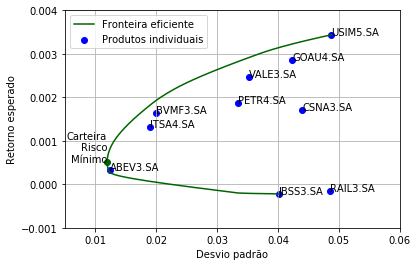

In [43]:
ax = plt.gca()
ax.scatter(x=desvios, y=retornos, color='Blue', label='Produtos individuais')

for i, produto in enumerate(produtos):
    ax.annotate(produto, (desvios[i], retornos[i]))

ax.scatter(x=risco_minimo_desvio, y=risco_minimo_retorno, color='DarkGreen')
ax.annotate('Carteira\nRisco\nMínimo', (risco_minimo_desvio, risco_minimo_retorno), horizontalalignment='right')

fronteira_eficiente.plot(color='DarkGreen', label='Fronteira eficiente', ax=ax)

ax.axis([0.005, 0.06, -0.001, 0.004])
ax.set_xlabel('Desvio padrão')
ax.set_ylabel('Retorno esperado')
ax.legend()
ax.grid()
plt.show()